# TP3 Alejandro balladares 101118

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") 

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
#1Jd247D2BPj4ry7kpzK71fMtnyzOYa9M_
id_train_identity = '1Jd247D2BPj4ry7kpzK71fMtnyzOYa9M_'
downloaded = drive.CreateFile({'id': id_train_identity})
downloaded.GetContentFile('train_identity.csv')

df_train_identity = pd.read_csv('train_identity.csv')
#df_train_identity.head().T

In [6]:
#"1ToBfhZrshAHYsrW3FXVPxuPT-Vm5-8NB"

id_train_transaction = '1ToBfhZrshAHYsrW3FXVPxuPT-Vm5-8NB'
downloaded = drive.CreateFile({'id': id_train_transaction})
downloaded.GetContentFile('train_transaction.csv')

df_train_transaction = pd.read_csv('train_transaction.csv')
#df_train_transaction.head().T

# Parte III: Machine Learning (10 puntos)

Entrenar 2 (de tipos distintos, excluyendo regresiones logísticas) modelos (5 puntos cada
uno) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación
respecto de los de train?).

Los modelos deben cumplir las siguientes condiciones:

● Deben utilizar AUC-ROC como métrica de validación.

● Deben medirse solo en validación, no contra la competencia.

● Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).

● Deben tener un score en validación superior a 0,8.

● Para el feature engineering debe utilizarse imputación de nulos, mean encoding y
one hot encoding al menos una vez cada uno.

● Deben utilizar al menos 80 features (contando cómo features columnas con
números, pueden venir varios de la misma variable).

● Deben utilizar las columnas: id_31, id_33, DeviceType, DeviceInfo.

● Deben utilizar CountVectorizer o TfIdfVectorizer para algún feature.
Deberán contestar la siguiente pregunta:

● Para el mejor modelo de ambos, ¿cuál es el score en la competencia? (guardar el
csv con predicciones para entregarlo después)

# Criterios de correción

Parte III
Vamos a corregir los siguientes puntos en cada modelo de 5 puntos (a medida se acumulan
estos pueden hacer que el modelo valga 0, pero nunca negativo):

● Para cada modelo cada condición no cumplida (o mal hecha) resta 1 punto.

● Feature engineering inapropiado para el modelo elegido (-2 puntos), ejemplos:
features que no están normalizadas para una red neuronal, features sin ninguna
consideración de escalas para un KNN, etc.

● No buscan para todos los hiperparametros importantes.
Además si un modelo diera un resultado menor a 0,6 en validación se invalida entero.
Por sobre el puntaje total del ejercicio (ambos modelos) se restan 3 puntos si cualquiera de
las siguientes cosas suceden (no acumulables): eligen mal el mejor modelo entre los dos o
la predicción para la competencia no está bien hecha o la predicción en la competencia da
menos de 0.5.

In [7]:
df_train = pd.merge(df_train_identity, df_train_transaction, how='outer',on='TransactionID')

del df_train_identity
del df_train_transaction

# Armo los data sets

In [8]:
columnas_mas_importantes_Lineal = ['id_14','TransactionAmt','card2', 'card3','card5', 'addr1', 'addr2', 'dist1', 'C13',
 'D1', 'D2', 'D4', 'D8', 'D10', 'D11', 'D15', 'V130', 'V133', 'V159', 'V203', 'V207', 'V263', 'V265', 'V267', 'V273',
 'V275', 'V307', 'V308', 'V310', 'V318', 'V331'] #las más importantes de la regresion lineal

columnas_con_mas_correlacion_con_isFraud = ['id_17','card3',
'V15','V16','V17','V18','V21','V22','V31','V32','V33','V34','V37','V38','V39','V40','V42','V43','V44','V45','V47','V50','V51','V52','V57','V58','V59',
'V60','V63','V64','V71','V72','V73','V74','V77','V78','V79','V80','V81','V84','V85','V86','V87','V92','V93','V94',
'V140','V146','V147','V148','V149','V153','V154','V155','V156','V157','V158','V170','V171','V176','V188','V189','V190','V197','V199',
'V200','V201','V222','V228','V230','V242','V243','V244','V246','V247','V252','V257','V258','V259','V262']

In [9]:
categoricas_booleanas = ['M1','M2','M3', 'M5','M6','M7','M8','M9','id_12','id_16', 'id_29', 'id_35','id_36','id_37','id_38'] #'id_27',
categoricas_binary = ['P_emaildomain', 'R_emaildomain', 'id_30','id_31','DeviceInfo'] #'id_33', 
categoricas_oneHot = ['ProductCD', 'card4', 'card6', 'M4', 'id_15', 'id_28', 'id_34', 'DeviceType'] #'id_23', 

columnas_para_mean =['id_14',	'id_17',	'D2','D4','D8','D10',	'D11'	,'D15','V159','V203', 'V207','V263', 'V265','V267',
                     'V268','V273', 'V275','V331', 'V333']

columnas_con_pocos_valores = ['V15', 'V16','V17','V18','V21', 'V22', 'V31', 'V32','V33','V34','V37','V38','V39','V40','V42', 'V43','V44','V45','V47', 
                              'V50', 'V51', 'V52', 'V57', 'V58','V59','V60','V61', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74','V77','V78' ,'V79',
                              'V80','V81', 'V84', 'V85','V86','V87', 'V92', 'V93','V140',
                              'V146','V147','V148','V149','V153', 'V154','V155','V156','V157','V158','V170','V171','V172','V176','V187','V188','V189',
                              'V190','V197','V198','V199','V200','V201','V222','V223','V224','V228','V230','V242','V243','V244','V246','V247','V252',
                              'V257','V258','V259','V262','V323'
                              ]

columnas_a_utilizar = ['id_12','id_14','id_15','id_16','id_17', 'id_28','id_29','id_30','id_31',#'id_33',
                      'id_34', 'id_35','id_36','id_37','id_38',
                      'TransactionAmt','card2', 'card3','card4','card5' ,'card6', 'addr1', 'addr2', 'dist1',
                      'C7', 'C8', 'C11', 'C12', 'C13', 'C14',
                      'D1', 'D2', 'D4', 'D8', 'D10', 'D11', 'D15',
                      'V12', 'V15','V16','V17','V18','V21','V22','V31','V32','V33','V34','V37','V38','V39','V40','V42','V43','V44','V45','V47',
                       'V50','V51','V52','V57','V58','V59','V60','V61','V63','V64','V71','V72','V73', 'V74','V77','V78','V79',
                       'V80','V81','V84','V85','V86','V87','V92','V93','V94',
                      'V130', 'V133','V140','V146','V147','V148', 'V149', 'V153', 'V154','V155','V156','V157','V158','V159','V163', 
                      'V170','V171','V172', 'V176','V187','V188','V189', 'V190', 'V197', 'V198','V199',
                      'V200','V201', 'V203', 'V207','V222','V223', 'V224','V228','V230','V242','V243','V244','V246','V247','V252','V257','V258','V259',
                      'V262', 'V263','V265',  'V266','V267',  'V268', 'V273','V275', 'V283', 'V294', 'V295',
                      'V307', 'V308', 'V310', 'V317','V318', 'V323','V331','V333',   
                      'M1','M2','M3','M4', 'M5','M6','M7','M8','M9',
                      'P_emaildomain', 'R_emaildomain', 'DeviceInfo','ProductCD',  'DeviceType', 'isFraud','ancho_pantalla','alto_pantalla'
                      ]

opcion_1 = [0,1,2]
opcion_2 = [0,1]
opcion_3 = [1,2,3]
opcion_4 = [1,2,3,4]
opcion_5 = [1,2,3,4,5]
opcion_6 = [0,1,2,3]

diccionario_para_rellenar = {'V17':opcion_1,'V18':opcion_1,'V32':opcion_1,'V34':opcion_1,'V39':opcion_1,'V40':opcion_1,'V43':opcion_1,
                             'V51':opcion_1,'V52':opcion_1,'V59':opcion_1,
            'V60':opcion_1,'V74':opcion_1, 'V79':opcion_1,'V80':opcion_1,'V81':opcion_1,'V85':opcion_1,'V86':opcion_1,'V146':opcion_1,'V147':opcion_1,'V157':opcion_1,
            'V158':opcion_1,'V188':opcion_1,'V189':opcion_1,'V197':opcion_1,'V224':opcion_1,'V262':opcion_1,'V323':opcion_1,
            
            'V15':opcion_2,'V16':opcion_2,'V21':opcion_2,'V22':opcion_2,'V31':opcion_2,'V33':opcion_2, 'V42':opcion_2,'V50':opcion_2,
            'V57':opcion_2, 'V58':opcion_2, 'V61':opcion_2, 'V63':opcion_2, 'V64':opcion_2,'V71':opcion_2, 'V72':opcion_2, 'V73':opcion_2,
            'V84':opcion_2, 'V92':opcion_2,'V93':opcion_2,
            'V148':opcion_2,'V149':opcion_2,'V153':opcion_2,'V154':opcion_2,'V155':opcion_2,'V156':opcion_2,'V172':opcion_2,'V198':opcion_2,'V223':opcion_2,
            'V223':opcion_2,'V242':opcion_2,'V244':opcion_2,'V246':opcion_2,'V247':opcion_2,'V252':opcion_2,
            
            'V45':opcion_3,'V44':opcion_3,'V87':opcion_3,'V176':opcion_3,
            'V37':opcion_4,
            'V38':opcion_5,
            
            'V47':opcion_6,'V77':opcion_6,'V78':opcion_6,'V140':opcion_6,'V170':opcion_6,'V171':opcion_6,'V187':opcion_6,'V190':opcion_6,'V199':opcion_6,
            'V200':opcion_6,'V201':opcion_6,'V222':opcion_6,'V228':opcion_6,'V230':opcion_6,'V243':opcion_6,'V257':opcion_6,'V258':opcion_6,
            'V259':opcion_6
            }

In [10]:
def llenarValores(df):  #para usar el countVectorizer no puede haber nans en las columnas
  values = {'id_30':'Desconocido','id_33':'0'}
  df.fillna(value=values,inplace=True)

def pixeles_ancho(x):
  if x == '0':
    return 0
  n = 0
  for c in x:
    if c == "x":
      break
    n += 1
  valor_ancho = x[:n]
  return int(valor_ancho)

def pixeles_alto(x):
  if x == '0':
    return 0
  n = 0
  for c in x:
    if c == "x":
      break
    n += 1
  valor_alto = x[n+1:]
  return int(valor_alto)

In [11]:
llenarValores(df_train)
df_train['ancho_pantalla'] = df_train['id_33'].transform(pixeles_ancho)
df_train['alto_pantalla'] = df_train['id_33'].transform(pixeles_alto)

In [12]:
df_train = df_train.sort_values('TransactionDT',ascending=True)
df_train.drop(columns=['TransactionID'], inplace=True)

In [14]:
df_train = df_train[columnas_a_utilizar]
limite = int(len(df_train)*0.7)

train = df_train[:limite]
test = df_train[limite:]

In [15]:
top_7 = ['chrome 63.0', 'mobile safari 11.0', 'mobile safari generic',
       'ie 11.0 for desktop', 'safari generic', 'chrome 62.0', 'chrome 65.0']

df_aux = df_train
df_aux['id_31'] = df_train['id_31'].transform(lambda x: 'otro' if x not in top_7 else x)
df_aux = df_aux.groupby('id_31')['isFraud'].agg({'mean'})
df_aux = df_aux.reset_index()

top_8_id_31 = {}
for i in range(len(df_aux)):
  top_8_id_31[df_aux.loc[i,"id_31"]] = df_aux.loc[i,"mean"]

del df_aux

#----------------------------------------------------------

df_aux = df_train.groupby('card4')['isFraud'].agg({'mean'})
df_aux = df_aux.reset_index()
df_aux
diccionario_mean_card4_target = {}
for i in range(len(df_aux)):
   diccionario_mean_card4_target[df_aux.loc[i,"card4"]] = df_aux.loc[i,"mean"]

del df_aux

In [16]:
Y_train = train['isFraud']
X_train = train.drop(columns=['isFraud']) 
del train

Y_test = test['isFraud']
X_test = test.drop(columns=['isFraud'])
del test

# Encodings

Para el feature engineering debe utilizarse imputación de nulos, mean encoding y
one hot encoding al menos una vez cada uno.

● Deben utilizar al menos 80 features (contando cómo features columnas con
números, pueden venir varios de la misma variable).

● Deben utilizar las columnas: id_31, id_33, DeviceType, DeviceInfo.

● Deben utilizar CountVectorizer o TfIdfVectorizer para algún feature.
Deberán contestar la siguiente pregunta:

In [20]:
diccionario_mean = {}
def crear_diccionario_mean(columnas):
  for columna in columnas:
    valor = X_train[columna].agg('mean')
    diccionario_mean[columna] = valor

def rellenar_mean(df,columnas, dict):
  for columna in columnas:
    valor = dict[columna]
    df[columna].fillna(value=valor, inplace=True)


def transformar_columnas(df, columnas, dict):
  for columna in columnas:
    valores = dict[columna]
    df[columna].transform(lambda x: x if x in valores else -1)
    
crear_diccionario_mean(columnas_para_mean)

#---------------------------------------------------------------

vectorizer_id_30 = CountVectorizer()
X = vectorizer_id_30.fit_transform(X_train['id_30'])
#vectorizer.get_feature_names_out()#[25:] #a partir de la pos 25 tengo datos utiles

indice_X_train = X_train.index
indice_X_test = X_test.index

def auxiliar_id_30(datos, vectorizer, n, indice):  
  lista_aux = vectorizer.get_feature_names_out()[n:]
  matriz = datos.toarray()
  valores_aux = []
  for j in range(len(matriz)):
    valores_aux.append(matriz[j][n:])
  df = pd.DataFrame(valores_aux, columns=lista_aux)
  df['index'] = indice
  df.set_index('index',inplace=True)
  df.index.name = None
  return df

def transformar_id_30(df, vectorizer, n, indices):
  datos = vectorizer.transform(df)
  df_aux = auxiliar_id_30(datos,vectorizer,n, indices)
  return df_aux


X_train_id_30 = auxiliar_id_30(X,vectorizer_id_30,25,indice_X_train)
X = None
#X_train_id_30
#vectorizer_id_30.vocabulary_

#------------------------------------------------------------------

one_hot_encoder = ce.OneHotEncoder(cols=categoricas_oneHot ,handle_unknown='return_nan',return_df=True, use_cat_names=True)

def one_hot_enconding(df_train, encoder):
  one_hot_encoded = encoder.fit_transform(df_train)
  return one_hot_encoded

#--------------------------------------------------------------------

def transformar_mean_encoding_card4(x):
  try:
    valor = diccionario_mean_card4_target[x]
  except:
    return 0
  return valor

def transformar_mean_encoding_id_31(x):
  try:
    valor = top_8_id_31[x]
  except:
    return 0
  return valor

def mean_encoding(df):
  df['mean_id_31'] = df['id_31'].transform(transformar_mean_encoding_id_31)
  df['mean_card4'] = df['card4'].transform(transformar_mean_encoding_card4)

#--------------------------------------------------------------------

def convertirBooleano_aux(x):
  if (x == 'T') or (x == 'Found'):
    return 1
  elif (x == 'F') or (x == 'Not found'):
    return 0
  return -1

def convertirBoleanoo(df, columnas):
  for columna in columnas:
    columna_encodeada = df[columna].transform(convertirBooleano_aux)      
    df[columna] = columna_encodeada

#-------------------------------------------------------------------

BinaryEncoder = ce.BinaryEncoder()
def binary_encoder(df_train, encoder):
  BinaryEncodeing = encoder.fit_transform(df_train[categoricas_binary])
  df_train = pd.concat([df_train, BinaryEncodeing], axis=1)
  df_train.drop(columns=categoricas_binary,inplace=True)
  del BinaryEncodeing
  return df_train

def encodeo_binario(df, columnas):  
  aux = df[columnas]
  aux = BinaryEncoder.transform(aux, override_return_df=True)
  df = pd.concat([df, aux], axis=1)
  df.drop(columns=categoricas_binary, inplace=True)
  del aux
  return df

In [22]:
X_test_id_30 = transformar_id_30(X_test['id_30'], vectorizer_id_30, 25,indice_X_test)

#-----------------------------------------------------------------------

mean_encoding(X_train)
mean_encoding(X_test)

#-----------------------------------------------------------------------

convertirBoleanoo(X_train, categoricas_booleanas)
convertirBoleanoo(X_test, categoricas_booleanas)

#-----------------------------------------------------------------------

X_train = one_hot_enconding(X_train, one_hot_encoder)
X_test = one_hot_encoder.transform(X_test, override_return_df=True)

#-----------------------------------------------------------------------

X_train = binary_encoder(X_train, BinaryEncoder)
X_test = encodeo_binario(X_test, categoricas_binary)

#-----------------------------------------------------------------------

X_train = X_train.merge(X_train_id_30, left_index=True,right_index=True)
X_test = X_test.merge(X_test_id_30, left_index=True,right_index=True)

del X_test_id_30
del X_train_id_30

#-----------------------------------------------------------------------

rellenar_mean(X_train, columnas_para_mean, diccionario_mean)
rellenar_mean(X_test, columnas_para_mean, diccionario_mean)

transformar_columnas(X_train, columnas_con_pocos_valores,diccionario_para_rellenar)
transformar_columnas(X_test, columnas_con_pocos_valores,diccionario_para_rellenar)

X_train.fillna(value=-1, inplace=True)
X_test.fillna(value=-1, inplace=True)


# Modelo

In [26]:
def mostrar_metricas(y_test, y_pred, y_pred_proba):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix(y_test, y_pred))
    print('ROC: \n', roc_auc_score(y_test, y_pred_proba))

    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()

xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=10,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=0.3,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=12)

xgb.fit(X_train.values, Y_train.values, eval_metric='auc')

XGBClassifier(colsample_bytree=0.3, gamma=0.2, max_depth=10, min_child_weight=3,
              n_estimators=50, nthread=4, seed=12, subsample=0.6)

scores para el train y test: 0.9340791542998426 0.88860387411102
Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    171037
           1       0.84      0.30      0.44      6125

    accuracy                           0.97    177162
   macro avg       0.91      0.65      0.71    177162
weighted avg       0.97      0.97      0.97    177162

Matriz de confusión: 
 [[170685    352]
 [  4305   1820]]
ROC: 
 0.88860387411102


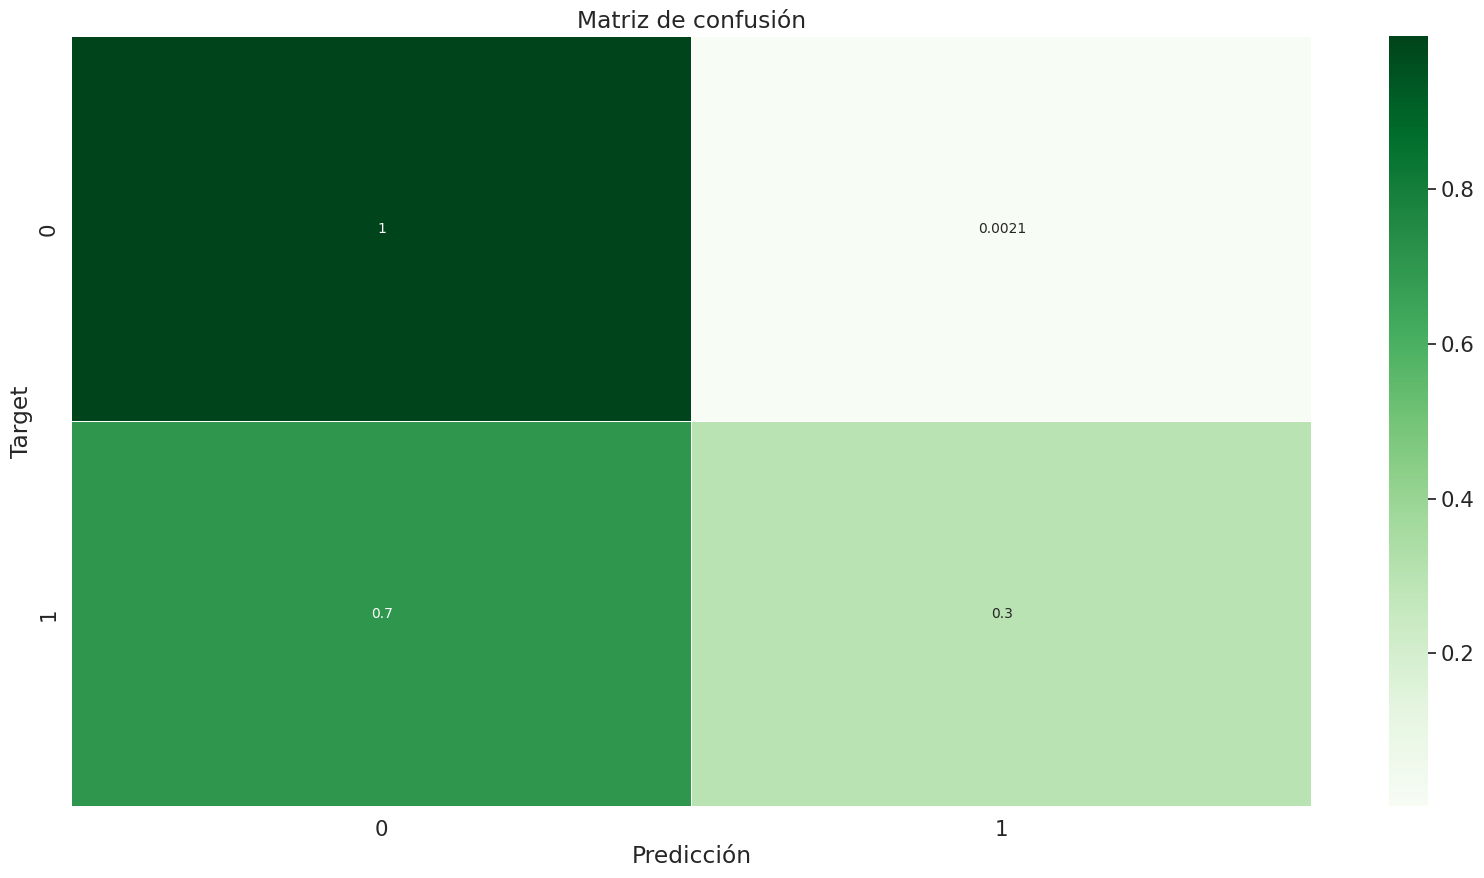

In [27]:
score_train = roc_auc_score(Y_train.values, xgb.predict_proba(X_train.values)[:,1])
score_test = roc_auc_score(Y_test.values, xgb.predict_proba(X_test.values)[:,1])
print("scores para el train y test:", score_train, score_test)

mostrar_metricas(Y_test.values, xgb.predict(X_test.values), xgb.predict_proba(X_test.values)[:,1])


In [28]:
def randomSearch(modelo, kfold=None):
  
  parameters = {'learning_rate': [0.1,0.2], 
                'max_depth': [5,7,10,15],
                'min_child_weight': [3,5,7,15],
                'n_estimators': [100,150,200],
                "gamma"       : [0.2,0.4],
                }

  clf = RandomizedSearchCV(modelo, parameters, n_iter=50, cv = 2, verbose=100, random_state=7506) #no tuve tiempo para probar más combinaciones
  search = clf.fit(X_train.values, Y_train.values)
  print(search.best_params_)
  return search.best_params_

resultado = {'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.4}

#resultado = randomSearch(xgb)

del xgb

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    171037
           1       0.82      0.33      0.47      6125

    accuracy                           0.97    177162
   macro avg       0.90      0.66      0.73    177162
weighted avg       0.97      0.97      0.97    177162

Matriz de confusión: 
 [[170603    434]
 [  4090   2035]]
ROC: 
 0.9047775073850234


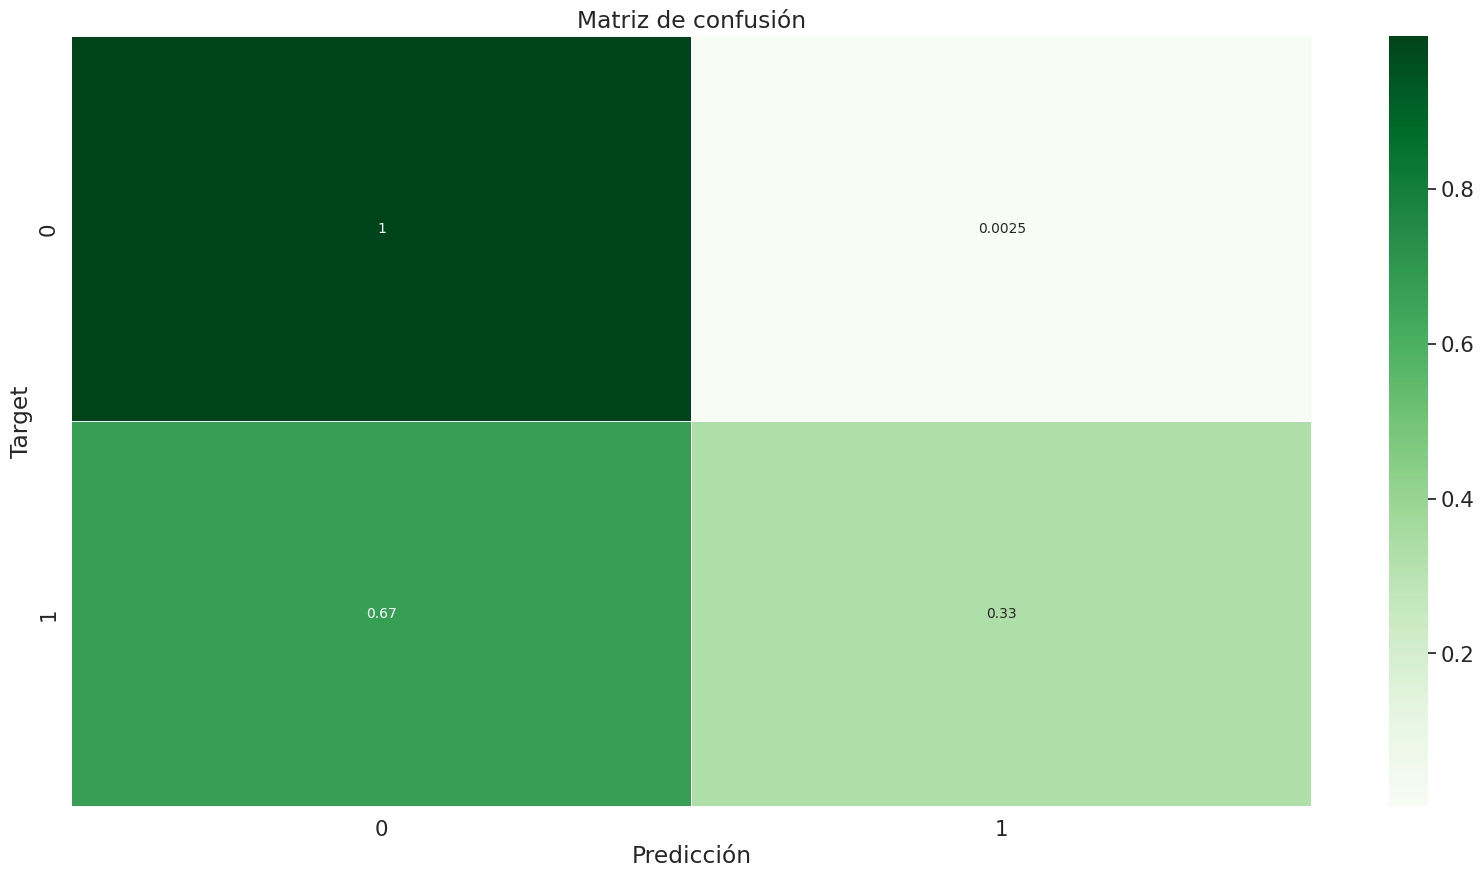

In [29]:
resultado = {'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.2}
#es lo que me devolvió el random search

n_estimators_best = resultado['n_estimators']
min_child_weight_best = resultado['min_child_weight']
max_depth_best = resultado['max_depth']
learning_rate_best= resultado['learning_rate']
gamma_best = resultado['gamma']

def best_intento():
  xgb_tuneado = XGBClassifier(learning_rate=learning_rate_best, n_estimators=n_estimators_best, max_depth=max_depth_best,
                      min_child_weight=min_child_weight_best, gamma=gamma_best, subsample=0.6, colsample_bytree=0.3,
                      objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=12)

  xgb_tuneado.fit(X_train.values, Y_train.values, eval_metric='auc')
  mostrar_metricas(Y_test.values, xgb_tuneado.predict(X_test.values), xgb_tuneado.predict_proba(X_test.values)[:,1])
  return xgb_tuneado
best_model = best_intento()

# Importancia de los features

El promedio es 0.004385964923513759


Text(0, 0.5, 'Importancia')

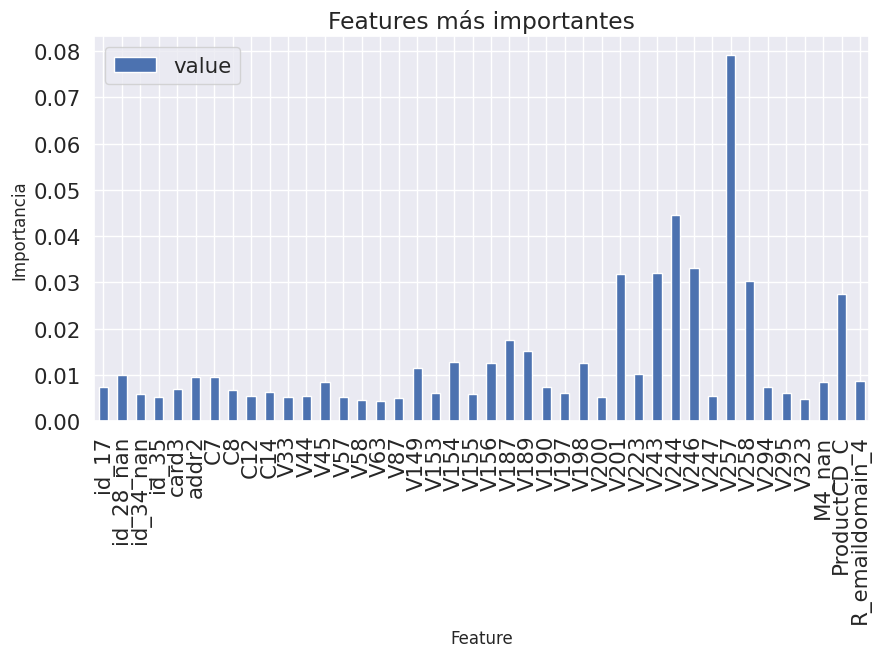

In [30]:
indices = []
valores = []
promedio = 0
importance = best_model.feature_importances_

for elemento in importance:
	promedio += elemento
promedio = promedio/len(importance)

print("El promedio es", promedio)

for i,v in enumerate(importance):
	if abs(v) > promedio: #0.006 
		indices.append(X_train.columns[i])
		valores.append(v)


df = pd.DataFrame({'indice': indices, 'value': valores})
df.set_index('indice',inplace=True)
df.plot(kind = 'bar', figsize = (10, 5),  title = "Features más importantes")
plt.xlabel('Feature', fontsize= 12)
plt.ylabel("Importancia", fontsize= 12)

# Test

In [31]:
del X_train
del X_test

In [32]:
id_test_identity ='1NxzemULNRkT-kqjYXeHV0gQmQK98NC1n'
downloaded = drive.CreateFile({'id': id_test_identity})
downloaded.GetContentFile('test_identity.csv')
df_test_identity = pd.read_csv('test_identity.csv')

id_test_transaction ='1y-MpYZTrnmzHMcVDPfYkpVFQetOy4zqN'
downloaded = drive.CreateFile({'id': id_test_transaction})
downloaded.GetContentFile('test_transaction.csv')
df_test_transaction = pd.read_csv('test_transaction.csv')


df_test = pd.merge(df_test_identity, df_test_transaction, how='outer',on='TransactionID')


In [33]:
df_test.set_index('TransactionID',inplace=True)
df_test.columns = df_test.columns.str.replace("id-","id_")

del df_test_identity
del df_test_transaction


In [34]:
columnas_a_utilizar.remove('isFraud')

llenarValores(df_test)
df_test['ancho_pantalla'] = df_test['id_33'].transform(pixeles_ancho)
df_test['alto_pantalla'] = df_test['id_33'].transform(pixeles_alto)

indice_X_test = df_test.index

df_test = df_test[columnas_a_utilizar]

df_test_id_30 = transformar_id_30(df_test['id_30'], vectorizer_id_30, 25,indice_X_test)

mean_encoding(df_test)

convertirBoleanoo(df_test, categoricas_booleanas)

df_test = one_hot_encoder.transform(df_test, override_return_df=True)
df_test = encodeo_binario(df_test, categoricas_binary)
df_test = df_test.merge(df_test_id_30, left_index=True,right_index=True)

del df_test_id_30

rellenar_mean(df_test, columnas_para_mean, diccionario_mean)
transformar_columnas(df_test, columnas_con_pocos_valores,diccionario_para_rellenar)

df_test.fillna(value=-1, inplace=True)

In [35]:
from google.colab import files
prediccion = best_model.predict_proba(df_test.values)[:,1]

In [36]:
def generarResultado(df,prediccion):
    df.index.rename('TransactionID',inplace=True)
    df['isFraud'] = prediccion
    resultado = df[['isFraud']]
    resultado.to_csv('resultadoXGB.csv')
    files.download('resultadoXGB.csv')
    return resultado

prediccion = generarResultado(df_test,prediccion)

prediccion

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,isFraud
TransactionID,
3663586,0.01
3663588,0.03
3663597,0.00
3663601,0.01
3663602,0.15
...,...
4170231,0.02
4170232,0.00
4170235,0.01
